In [56]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
x = sympy.Symbol('x')
y0 = np.array([0.15, 0.12, 0, 0.73])  # SO2, O2, SO3, N2
yA0 = 0.15
yB0 = 0.12
yC0 = 0
T_list = [600, 650, 700, 750, 800, 850, 900, 950, 1000] # in K
P_list = [1, 3, 10] # in atm
for T in T_list:
    P = 1
    Kp = np.exp(-10.68 + 11300 / T)  # in atm^-0.5
    xe=(sympy.solve(((yA0*x)*((1-yA0*0.5*x)**(1/2)))/(yA0*(1-x)*((yB0-yA0*0.5*x)**0.5)*(P**0.5))-Kp,'x'))
for T in T_list:
    P = 3
    Kp = np.exp(-10.68 + 11300 / T)  # in atm^-0.5
    xe = sympy.solve(((yA0*x)*((1-yA0*0.5*x)**0.5))/(yA0*(1-x)*((yB0-yA0*0.5*x)**0.5)*(P**0.5))-Kp,'x')
for T in T_list:
    P = 10
    Kp = np.exp(-10.68 + 11300 / T)  # in atm^-0.5
    xe = sympy.solve(((yA0*x)*((1-yA0*0.5*x)**0.5))/(yA0*(1-x)*((yB0-yA0*0.5*x)**0.5)*(P**0.5))-Kp,'x')

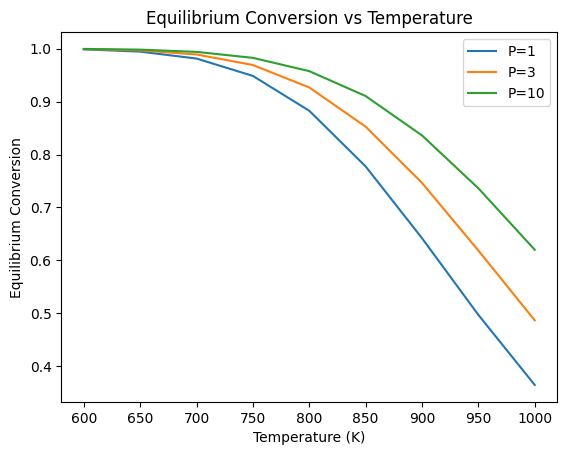

In [57]:
P1 = [0.998698321930585, 0.994499440550885, 0.98139971363592, 0.9485420356358, 0.882674118657921, 0.777525992576534, 0.641914511047059, 0.496912563006584, 0.364574501364816]
P3 = [0.999247735374091, 0.996811073897752, 0.989112022829728, 0.969177610680249, 0.926721981370186, 0.852671360829919, 0.746379818377695, 0.618528751283445, 0.486618898344271]
P10 = [0.999587716509763, 0.99824884756832, 0.99398417900821, 0.982705169240033, 0.957594871549611, 0.910499424237375, 0.836092862120465, 0.736160822769614, 0.620067290933213]
import matplotlib.pyplot as plt
# plot vs T_list
plt.plot(T_list, P1, label='P=1')
plt.plot(T_list, P3, label='P=3')
plt.plot(T_list, P10, label='P=10')
plt.xlabel('Temperature (K)')
plt.ylabel('Equilibrium Conversion')
plt.legend()
plt.title('Equilibrium Conversion vs Temperature')

# save plot to graphs folder
plt.savefig('graphs/Fig1.png')

|Temp|Xe @ P = 1 atm|Xe @ P = 3 atm|Xe @ P = 10 atm
|---|---|---|---|
|600|0.9987|0.9992|0.9996|
|650|0.9945|0.9968|0.9982|
|700|0.9814|0.9891|0.9940|
|750|0.9485|0.9692|0.9827|
|800|0.8827|0.9267|0.9576|
|850|0.7775|0.8527|0.9105|
|900|0.6419|0.7464|0.8361|
|950|0.4969|0.6185|0.7362|
|1000|0.3646|0.4866|0.6201|

In [58]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

def sulfox(y, z):
    # Adiabatic simulation of SO2 + 0.5 O2 ---> SO3 reaction in a PBR

    # Extract values from the input array `y`
    FSO2 = y[0]  # molar flow rate of SO2 in kmol/hr
    FO2 = y[1]
    FSO3 = y[2]  # molar flow rate of SO3
    FN2 = y[3]  # molar flow rate of N2
    T = y[4]
    P = y[5]  # in atm
    Ftotal = FSO2 + FO2 + FSO3 + FN2

    # Constants and parameters
    R = 8.314  # J/mol/K
    Kp = np.exp(-10.68 + 11300 / T)  # in atm^-0.5
    k1 = np.exp(12.16 - 5473 / T)  # kmol/kg-cat . atm^2 . h
    K2 = np.exp(-9.953 + 8619 / T)  # atm^-1
    K3 = np.exp(-71.745 + 52596 / T)  # atm^-1

    # Partial pressure calculation: pi = yi * P, yi = fi / ftotal
    pSO2 = (FSO2 / Ftotal) * P  # partial pressure of SO2 in atm
    pO2 = (FO2 / Ftotal) * P
    pSO3 = (FSO3 / Ftotal) * P
    pN2 = (FN2 / Ftotal) * P

    # Rate law: (-rSO2) = k1 * pO2 * pSO2 * (1 - beta) / denom
    beta = pSO3 / (Kp * pSO2 * pO2 ** 0.5)
    denom = 22.414 * (1 + K2 * pSO2 + K3 * pSO3) ** 2
    rate = k1 * pO2 * pSO2 * (1 - beta) / denom  # kmol/kg-cat-h

    # PBR parameters
    Dt = 10  # m
    por = 0.3  # porosity
    den_cat = 265  # BED density in kg/m^3
    Dp = 6.35e-3  # m; catalyst size is 6.35 mm
    Ac = np.pi * Dt ** 2 / 4  # cross-sectional area of PBR

    # Heat capacities Cp = R * (A + BT + CT^2 + D/T^2 + ET^3) in J/mol-K for ideal gas
    Cp = np.zeros(4)
    Cp[0] = 30.178 + 42.452e-3 * T - 18.218e-6 * T ** 2
    Cp[1] = 35.634 + 71.722e-3 * T - 31.539e-6 * T ** 2
    Cp[2] = 23.995 + 17.507e-3 * T - 6.628e-6 * T ** 2
    Cp[3] = 26.159 + 6.615e-3 * T - 2.889e-6 * T ** 2

    # Heat of reaction (Hrxn) at 700 K
    Hrxn_Tref = -98787.5  # J/mol
    Tref = 700
    #Hrxn = Hrxn_Tref  # placeholder for more detailed calculation
    Hrxn = Hrxn_Tref - 6.54 * (T - Tref) + (0.0205 / 2) * (T**2 - Tref**2) - (10.007e-6 / 3) * (T**3 - Tref**3)

    # Heat capacity flow calculation
    ftcp = (FSO2 * Cp[0] + FO2 * Cp[1] + FSO3 * Cp[2] + FN2 * Cp[3]) * 1000  # J/h-K

    # Differential equations
    rate1 = rate * den_cat * Ac * (1 - por)  # units: kmol/kg_cat-hr * kg_cat/m^3_bed * m^2_bed

    dfdz = np.zeros_like(y)  # Initialize the result array
    
    # df/dz for each component
    dfdz[0] = -rate1  # dFSO2/dz = -rate * catalyst bed area
    dfdz[1] = -0.5 * rate1  # 0.5 is based on oxygen stoichiometry
    dfdz[2] = rate1  # dFSO3/dz
    dfdz[3] = 0  # N2 is inert
    dfdz[4] = (-rate1) * (Hrxn * 1000) / ftcp  # Temperature change calculation
    dfdz[5] = 0  # dP/dz (Isobaric, no pressure change)

    return dfdz

# Initial conditions
FT0 = 3000 # kmol/hr
P0 = 3.0 # atm

# Reactor length
Lspan = np.linspace(0, 0.2, 100)  # m

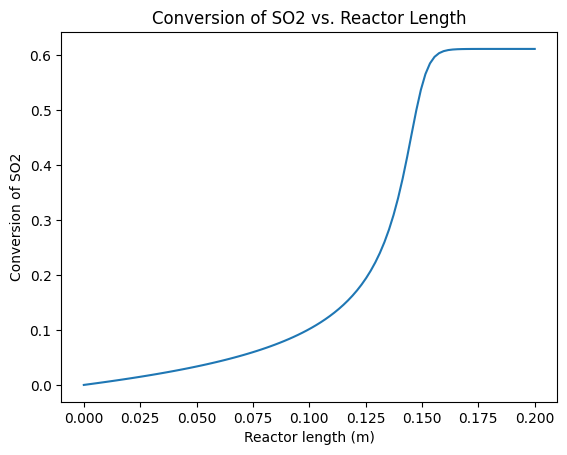

In [59]:
#plot X (conversion of SO2) vs L
plt.figsize=(10,10)
T0 = 700 # K
# Initial molar flow rates
y0 = [FT0 * 0.15, FT0 * 0.12, 0, FT0 * 0.73, T0, P0]  # SO2, O2, SO3, N2
sol = odeint(sulfox, y0, Lspan)
X = (y0[0] - sol[:, 0]) / y0[0]
plt.plot(Lspan, X, label='T = 700 K')
plt.xlabel('Reactor length (m)')
plt.ylabel('Conversion of SO2')
plt.title('Conversion of SO2 vs. Reactor Length')
# save plot to graphs folder
plt.savefig('graphs/Fig2.png')


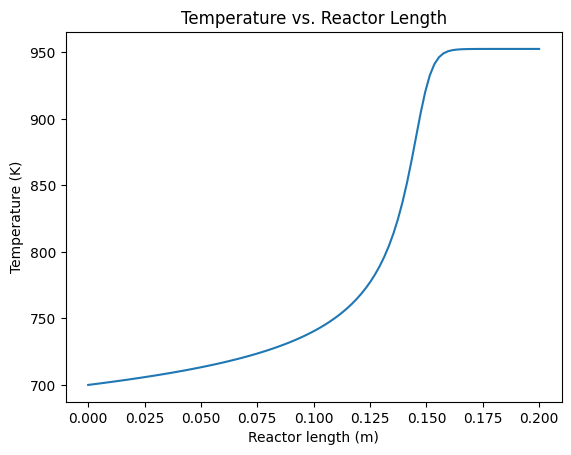

In [60]:
#plot T vs L
plt.figsize=(10,10)
plt.plot(Lspan, sol[:, 4], label='T = 700 K')
plt.xlabel('Reactor length (m)')
plt.ylabel('Temperature (K)')
plt.title('Temperature vs. Reactor Length')
# save plot to graphs folder
plt.savefig('graphs/Fig3.png')

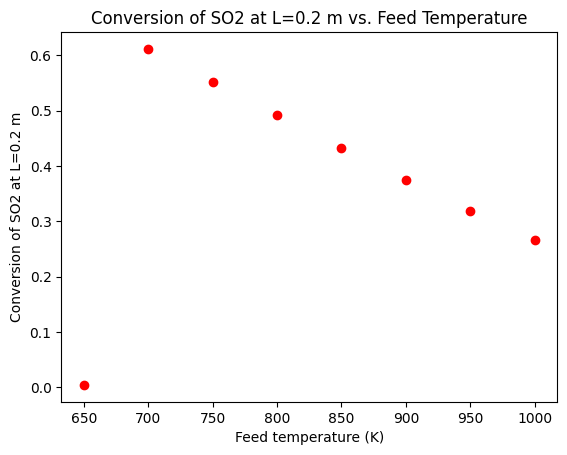

In [61]:
T_feed = [650, 700, 750, 800, 850, 900, 950, 1000]  # K

# Plot conversion of SO2 at length 0.2 m vs T_feed for different feed temperatures
plt.figure()
for T in T_feed:
    y0 = [FT0 * 0.15, FT0 * 0.12, 0, FT0 * 0.73, T, P0]  # SO2, O2, SO3, N2
    sol = odeint(sulfox, y0, Lspan)
    X = (y0[0] - sol[:, 0]) / y0[0]
    plt.plot(T, X[-1], 'ro')
plt.xlabel('Feed temperature (K)')
plt.ylabel('Conversion of SO2 at L=0.2 m')
plt.title('Conversion of SO2 at L=0.2 m vs. Feed Temperature')

# save plot to graphs folder
plt.savefig('graphs/Fig4.png')

T_max = 694.3434343434343, X_max = 0.6176596360778447


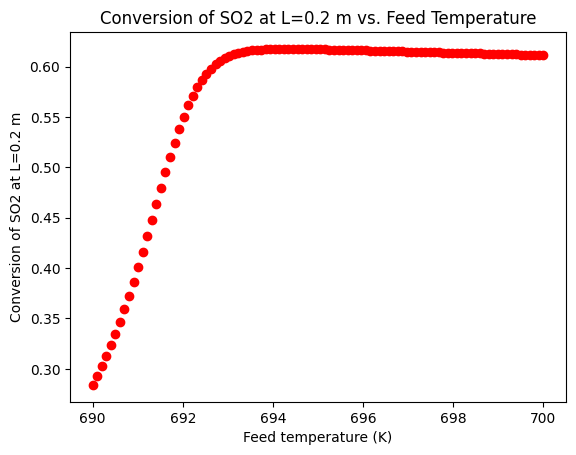

In [62]:
# get temperature of highest conversion, iterate through 690 to 700
T_feed_scan = np.linspace(690, 700, 100)  # K
X_max = 0
plt.figure()
for T in T_feed_scan:
    y0 = [FT0 * 0.15, FT0 * 0.12, 0, FT0 * 0.73, T, P0]  # SO2, O2, SO3, N2
    sol = odeint(sulfox, y0, Lspan)
    X = (y0[0] - sol[:, 0]) / y0[0]
    if X[-1] > X_max:
        X_max = X[-1]
        T_max = T
    plt.plot(T, X[-1], 'ro')
print(f'T_max = {T_max}, X_max = {X_max}')
plt.xlabel('Feed temperature (K)')
plt.ylabel('Conversion of SO2 at L=0.2 m')
plt.title('Conversion of SO2 at L=0.2 m vs. Feed Temperature')
# save plot to graphs folder
plt.savefig('graphs/Fig4.5.png')


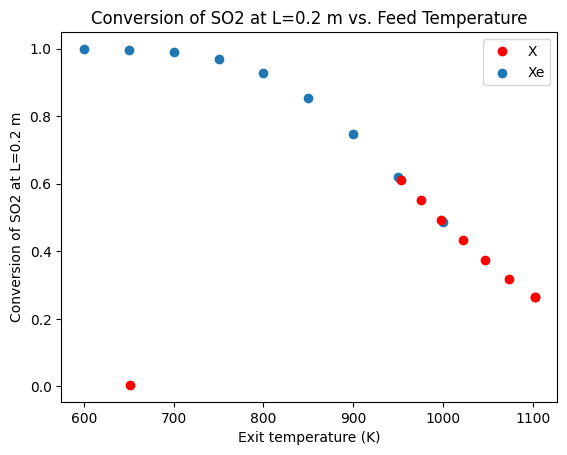

In [63]:
#Plot conversion of SO2 at length 0.2 m vs T_exit for different feed temperatures
# On the same plot, plot equilibrium conversion vs T for P=3 atm
plt.figure()
for T in T_feed:
    y0 = [FT0 * 0.15, FT0 * 0.12, 0, FT0 * 0.73, T, P0]  # SO2, O2, SO3, N2
    sol = odeint(sulfox, y0, Lspan)
    X = (y0[0] - sol[:, 0]) / y0[0]
    T_exit = sol[-1, 4]
    plt.plot(T_exit, X[-1], 'ro')
plt.plot(T_exit, X[-1], 'ro', label = 'X')
plt.scatter(T_list, P3, label='Xe')
plt.xlabel('Exit temperature (K)')
plt.ylabel('Conversion of SO2 at L=0.2 m')
plt.legend()
plt.title('Conversion of SO2 at L=0.2 m vs. Feed Temperature')
# save plot to graphs folder
plt.savefig('graphs/Fig5.png')


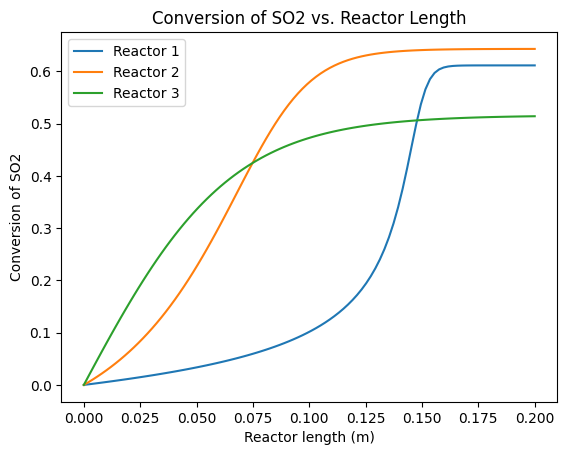

In [64]:
# 3 reactor beds with 2 interstage cooling
# optimum feed T=700K, plot X vs L
plt.figure()
FT0 = 3000 # kmol/hr
P0 = 3.0 # atm
T0 = 700 # K
Lspan = np.linspace(0, 0.2, 100)  # m
y0 = [FT0 * 0.15, FT0 * 0.12, 0, FT0 * 0.73, T0, P0]  # SO2, O2, SO3, N2
sol1 = odeint(sulfox, y0, Lspan)
X = (y0[0] - sol1[:, 0]) / y0[0]
plt.plot(Lspan, X, label='Reactor 1')
T1 = 730 # K
y1 = [sol1[-1, 0], sol1[-1, 1], sol1[-1, 2], sol1[-1, 3], T1, P0]
sol2 = odeint(sulfox, y1, Lspan)
X = (y1[0] - sol2[:, 0]) / y1[0]
plt.plot(Lspan, X, label='Reactor 2')
T2 = 760 # K
y2 = [sol2[-1, 0], sol2[-1, 1], sol2[-1, 2], sol2[-1, 3], T2, P0]
sol3 = odeint(sulfox, y2, Lspan)
X = (y2[0] - sol3[:, 0]) / y2[0]
plt.plot(Lspan, X, label='Reactor 3')
plt.xlabel('Reactor length (m)')
plt.ylabel('Conversion of SO2')
plt.title('Conversion of SO2 vs. Reactor Length')
plt.legend()
# save plot to graphs folder
plt.savefig('graphs/Fig6.png')

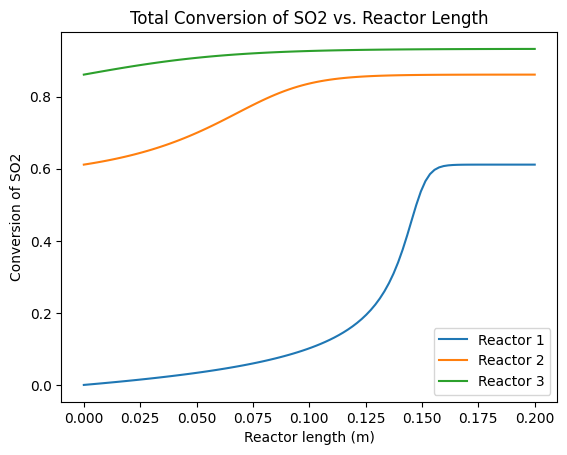

In [65]:
# Total conversion for each reactor
plt.figure()
X1 = (y0[0] - sol1[:, 0]) / y0[0]
X2 = (y0[0] - sol2[:, 0]) / y0[0]
X3 = (y0[0] - sol3[:, 0]) / y0[0]
plt.plot(Lspan, X1, label='Reactor 1')
plt.plot(Lspan, X2, label='Reactor 2')
plt.plot(Lspan, X3, label='Reactor 3')
plt.xlabel('Reactor length (m)')
plt.ylabel('Conversion of SO2')
plt.title('Total Conversion of SO2 vs. Reactor Length')
plt.legend()
# save plot to graphs folder
plt.savefig('graphs/Fig6.5.png')

Final conversion at end of 3rd reactor = 0.9326189651794409


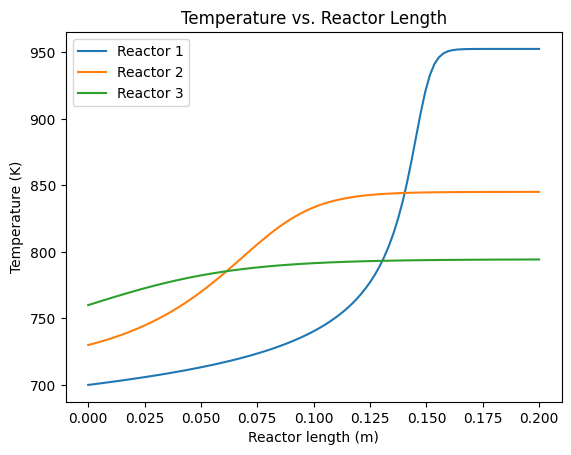

In [66]:
# plot T vs L for each reactor
plt.figure()
plt.plot(Lspan, sol1[:, 4], label='Reactor 1')
plt.plot(Lspan, sol2[:, 4], label='Reactor 2')
plt.plot(Lspan, sol3[:, 4], label='Reactor 3')
plt.xlabel('Reactor length (m)')
plt.ylabel('Temperature (K)')
plt.title('Temperature vs. Reactor Length')
plt.legend()
plt.savefig('graphs/Fig7.png')

# get final conversion at end of 3rd reactor
X = (y0[0] - sol3[-1, 0]) / y0[0]
print(f'Final conversion at end of 3rd reactor = {X}')